# 1. Setup and Configuration


In [70]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import logging



In [71]:
# Add project root to path
project_root = Path().absolute().parent
sys.path.append(str(project_root))

In [72]:
# Import project modules
from src.utils.utils import load_config, setup_logging, create_directories, get_device
from src.data.dataset import load_sequences, create_data_loaders
from src.data.preprocessing import DataPreprocessor
from src.models.motion_lstm import MotionLSTM
from src.models.training import Trainer, get_optimizer, get_criterion
from src.visualization.visualizer import SkeletonVisualizer
from src.evaluation.test import ModelTester


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# Load configuration
config_path = 'config\config.yaml'
config = load_config(config_path)

In [74]:
# Setup logging and directories
setup_logging(config)
create_directories(config)


In [75]:
# Set device
device = get_device(config)
print(f"Using device: {device}")

Using device: cuda


# 2. Data Processing


In [7]:
## IMPORTANT: NO NEED TO RUN THIS CELL IF THE DATA ALREADY PROCESSED

# Initialize preprocessor
preprocessor = DataPreprocessor(config)
preprocessor.preprocess_all_data()

2025-01-08 12:57:35,294 - src.data.preprocessing - INFO - Found 1167 files in train directory
2025-01-08 12:57:35,294 - src.data.preprocessing - INFO - Processing data\train\p0_boxing_01.csv
2025-01-08 12:57:35,335 - src.data.preprocessing - INFO - Successfully preprocessed data\train\p0_boxing_01.csv
2025-01-08 12:57:35,335 - src.data.preprocessing - INFO - Processing data\train\p0_boxing_02.csv
2025-01-08 12:57:35,370 - src.data.preprocessing - INFO - Successfully preprocessed data\train\p0_boxing_02.csv
2025-01-08 12:57:35,371 - src.data.preprocessing - INFO - Processing data\train\p0_boxing_03.csv
2025-01-08 12:57:35,404 - src.data.preprocessing - INFO - Successfully preprocessed data\train\p0_boxing_03.csv
2025-01-08 12:57:35,406 - src.data.preprocessing - INFO - Processing data\train\p0_boxing_04.csv
2025-01-08 12:57:35,446 - src.data.preprocessing - INFO - Successfully preprocessed data\train\p0_boxing_04.csv
2025-01-08 12:57:35,447 - src.data.preprocessing - INFO - Processing d

In [76]:
# Load and prepare data
sequences, labels = load_sequences(config, dataset='train')
train_loader, val_loader, label_mapping = create_data_loaders(config, sequences, labels)

print(f"Number of classes: {len(label_mapping)}")
print(f"Label mapping: {label_mapping}")

2025-01-08 19:51:33,615 - src.data.dataset - INFO - Found 1167 sequences in train set
2025-01-08 19:51:41,748 - src.data.dataset - INFO - 
Sequence length statistics:
2025-01-08 19:51:41,748 - src.data.dataset - INFO - Min length: 103
2025-01-08 19:51:41,748 - src.data.dataset - INFO - Max length: 945
2025-01-08 19:51:41,748 - src.data.dataset - INFO - Mean length: 279.96
2025-01-08 19:51:41,748 - src.data.dataset - INFO - Median length: 276.00


Number of classes: 5
Label mapping: {'boxing': 0, 'drums': 1, 'guitar': 2, 'rowing': 3, 'violin': 4}


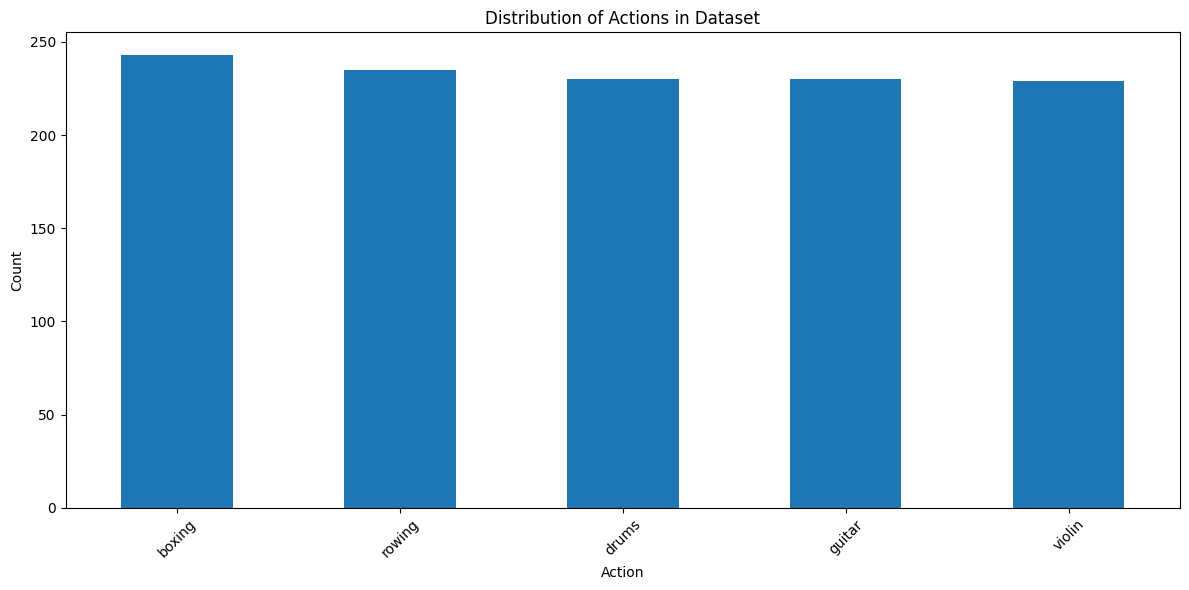

In [77]:
# Visualize data distribution
label_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Actions in Dataset')
plt.xlabel('Action')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Visualization


In [78]:
# Initialize visualizer
visualizer = SkeletonVisualizer(config)

In [15]:
video_path = visualizer.visualize_specific_sequence(
    subject=23,
    action='violin',
    iteration=7
)

print(f"Visualization saved to: {video_path}")

2025-01-08 13:44:02,249 - src.visualization.visualizer - INFO - Visualizing sequence: Subject 23, Action violin, Iteration 7
2025-01-08 13:44:38,792 - src.visualization.visualizer - INFO - Video saved to videos\p23_violin_7.mp4


Visualization saved to: videos\p23_violin_7.mp4


In [79]:
random_video_path = visualizer.visualize_random_sequence()

print(f"Visualization saved to: {random_video_path}")

2025-01-08 19:51:46,220 - src.visualization.visualizer - INFO - Visualizing sequence: Subject 8, Action boxing, Iteration 7
2025-01-08 19:52:11,909 - src.visualization.visualizer - INFO - Video saved to videos\p8_boxing_7.mp4


Visualization saved to: videos\p8_boxing_7.mp4


# 4. Model


In [110]:
# Initialize model
model = MotionLSTM(
    input_size=config['model']['input_size'],
    hidden_size=config['model']['hidden_size'],
    num_layers=config['model']['num_layers'],
    num_classes=len(label_mapping),
    num_attention_heads=config['model']['num_attention_heads'],
    dropout=config['model']['dropout']
).to(device)

In [111]:
# Print model summary
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

MotionLSTM(
  (input_bn): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(49, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

Total parameters: 4,966,503
Trainable parameters: 4,966,503


# 5. Training


In [112]:
# Initialize training components
criterion = get_criterion(config)
optimizer = get_optimizer(model, config)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    config=config,
    device=device,
    label_mapping=label_mapping
)

In [113]:
# Train the model
history = trainer.train()

2025-01-08 21:06:44,444 - src.models.training - INFO - Starting training...
2025-01-08 21:06:44,444 - src.models.training - INFO - 
Epoch 1/50
Validation: 100%|██████████| 15/15 [00:19<00:00,  1.27s/it]
2025-01-08 21:07:30,085 - src.models.training - INFO - Train Loss: 1.0319, Train Acc: 69.24%
Val Loss: 0.8978, Val Acc: 82.91%
2025-01-08 21:07:30,246 - src.models.training - INFO - 
Epoch 2/50
Validation: 100%|██████████| 15/15 [00:18<00:00,  1.24s/it]
2025-01-08 21:08:17,238 - src.models.training - INFO - Train Loss: 0.7113, Train Acc: 86.50%
Val Loss: 0.7949, Val Acc: 83.76%
2025-01-08 21:08:17,414 - src.models.training - INFO - 
Epoch 3/50
Validation: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]
2025-01-08 21:09:02,897 - src.models.training - INFO - Train Loss: 0.6769, Train Acc: 89.60%
Val Loss: 0.8323, Val Acc: 79.06%
2025-01-08 21:09:02,989 - src.models.training - INFO - 
Epoch 4/50
Validation: 100%|██████████| 15/15 [00:18<00:00,  1.26s/it]
2025-01-08 21:09:48,245 - src.model

# 6. Evaluation and Analysis


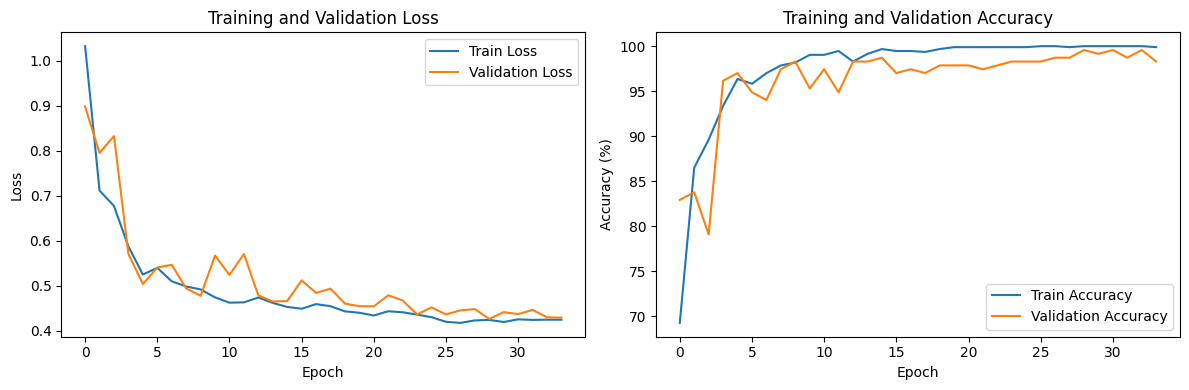

In [114]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accs'], label='Train Accuracy')
plt.plot(history['val_accs'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# 7. Testing


In [115]:
# Initialize model tester
model_tester = ModelTester(
    model=model,
    config=config,
    label_mapping=label_mapping,
    device=device
)

In [116]:
# Evaluate on test set
test_results = model_tester.evaluate_test_set()

2025-01-08 22:02:55,019 - src.evaluation.test - INFO - Loading test sequences...
2025-01-08 22:03:00,287 - src.evaluation.test - INFO - Loaded 305 test sequences
2025-01-08 22:03:00,287 - src.evaluation.test - INFO - Making predictions on test set...


In [117]:
# Print classification report
print("\nClassification Report:")
report_df = pd.DataFrame(test_results['classification_report']).transpose()
print(report_df)


Classification Report:
              precision    recall  f1-score     support
boxing         0.952381  1.000000  0.975610   60.000000
drums          0.882353  0.967742  0.923077   62.000000
guitar         0.764706  0.852459  0.806202   61.000000
rowing         1.000000  1.000000  1.000000   61.000000
violin         1.000000  0.737705  0.849057   61.000000
accuracy       0.911475  0.911475  0.911475    0.911475
macro avg      0.919888  0.911581  0.910789  305.000000
weighted avg   0.919658  0.911475  0.910617  305.000000


In [118]:
test_results['confusion_matrix']

array([[60,  0,  0,  0,  0],
       [ 0, 60,  2,  0,  0],
       [ 1,  8, 52,  0,  0],
       [ 0,  0,  0, 61,  0],
       [ 2,  0, 14,  0, 45]])


Confusion Matrix:


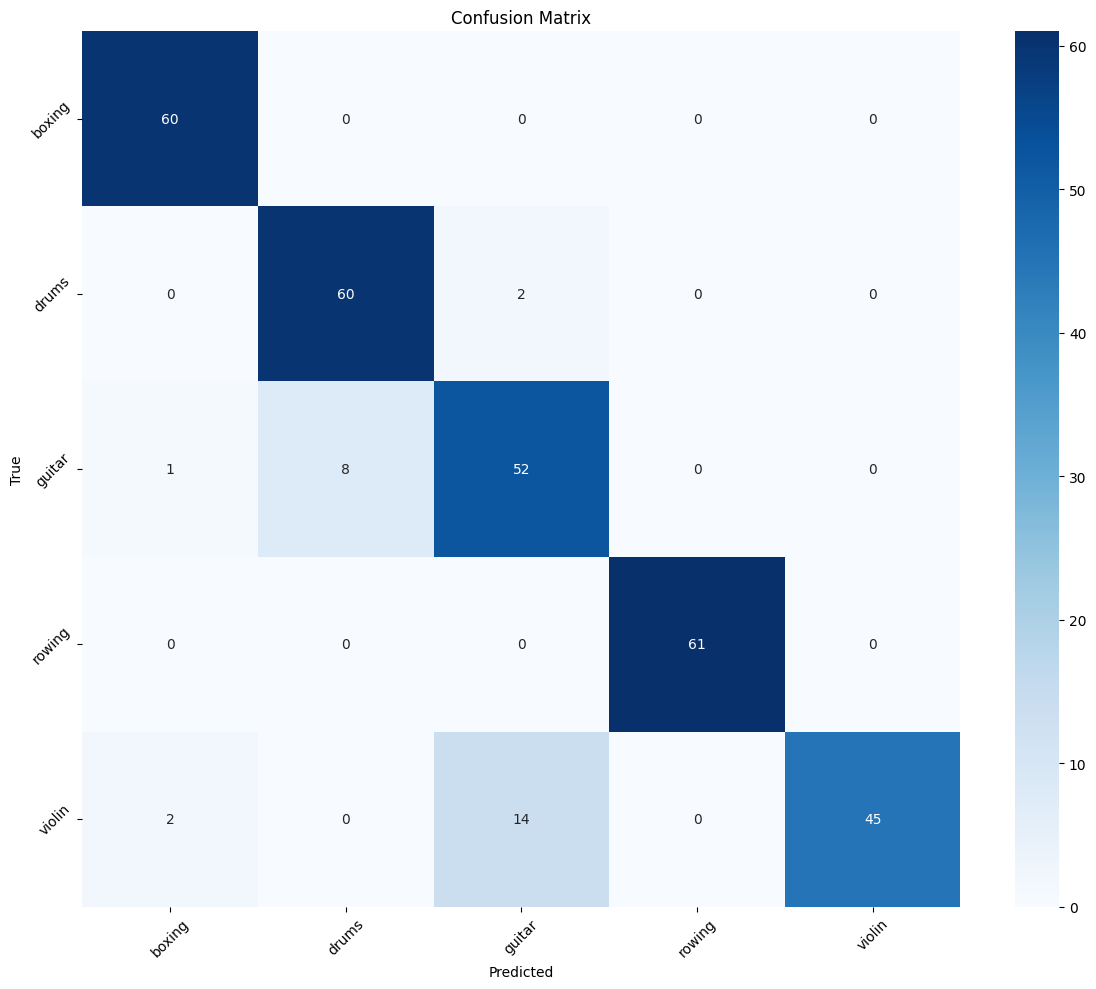

In [119]:
# Plot confusion matrix
print("\nConfusion Matrix:")
model_tester.plot_confusion_matrix(test_results['confusion_matrix'])

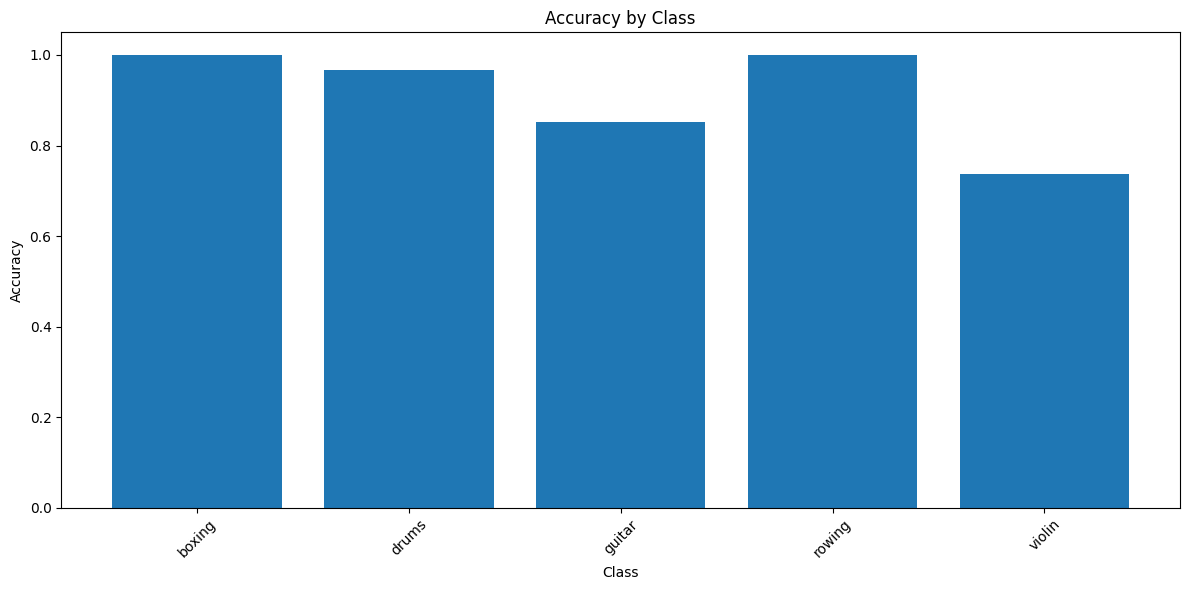

In [120]:
# Calculate per-class accuracy
class_accuracy = {}
for label in label_mapping:
    mask = np.array(test_results['true_labels']) == label
    correct = np.array(test_results['predictions'])[mask] == label
    accuracy = correct.mean() if len(correct) > 0 else 0
    class_accuracy[label] = accuracy
    
# Plot per-class accuracy
plt.figure(figsize=(12, 6))
plt.bar(class_accuracy.keys(), class_accuracy.values())
plt.title('Accuracy by Class')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()